# Start cuda

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Loading requirements

In [2]:
! pip install datasets

     |████████████████████████████████| 163kB 16.5MB/s 
     |████████████████████████████████| 245kB 28.8MB/s 
     |████████████████████████████████| 17.7MB 210kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [3]:
! pip install transformers

     |████████████████████████████████| 1.4MB 13.5MB/s 
     |████████████████████████████████| 2.9MB 56.1MB/s 
     |████████████████████████████████| 890kB 52.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b3953eaed48c69f91494640bd13985f793abfcb858f4d6f805bc9e26e69ff304
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Import things to get data to work
from datasets import load_from_disk
import sys
import os

# Loading data

In [5]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))
data_path = 'drive/My Drive/deep_learning_project/data/'

In [26]:
data = load_from_disk(data_path)

In [27]:
print(data[0])

{'answer': 'york', 'paragraph': 'judi dench born in dorset and later moved to dublin where he was raised he met dench s mother while he was studying medicine at trinity college dublin dench attended the mount school a quaker independent secondary school in york and became a quaker her brothers one of whom was actor jeffery dench were born in tyldesley lancashire her niece emma dench is a roman historian and professor previously at birkbeck university of london and currently at harvard university career in britain dench has developed a reputation as one of the greatest actresses of the post war period primarily through her work in theatre which has been her forte throughout her career she has more than once been named number one in polls for britain s best actor early years', 'question': 'Where in England was Dame Judi Dench born?', 'question_id': 'tc_3'}


# Training Model

In [9]:
from math import ceil
import torch
from transformers import AutoTokenizer, BertModel, AdamW

In [10]:
def get_loss(sim):
    nll = -(torch.diagonal(sim) - torch.logsumexp(sim, dim = 1))
    return sum(nll)# return negative loss

In [49]:
# Define data parameters
n_sample_train = 100
n_sample_validation = 10
batch_size = 10
n_batches = ceil(n_sample/batch_size)

# Define model parameters
lr = 5e-5
n_epochs = 4

# Define printing parameters
n_batch_print = 1 # Prints every (n_batch_print) during training

In [50]:
# NB CHANGE THIS CELL WHEN THE DATA IS READY###############
# Subset data
train_data = data.select(range(n_sample_train))
validation_data = data.select(range(n_sample_train, n_sample_train+n_sample_validation))

# Tokenize data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', padding = True)
train_data = train_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

validation_data = validation_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

#%% Change to pytorch format. 
train_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

validation_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

In [52]:
# Get pretrained model
model = BertModel.from_pretrained('bert-base-uncased')
optim = AdamW(model.parameters(), lr = lr)

# Move model to cuda to train there
model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [53]:
# The big loop :D 
epoch_train_loss = [None]*n_batches
epoch_validation_loss = [None]*n_batches
train_loss = [None]*n_epochs
validation_loss = [None]*n_epochs


for epoch in range(n_epochs):
    
    print(f'### EPOCH: {epoch+1}/{n_epochs} ###')

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    trainloader = iter(trainloader)
    validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    validationloader = iter(validationloader)
    
    # TRAINING MODEL
    model.train()
    for i, batch in enumerate(trainloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(trainloader)}')
        
        model.zero_grad()

        # (get extra observation in training set)

        # Move batch to cuda device
        P_input_ids = batch['P_input_ids'].to(device)
        P_attention_mask = batch['P_attention_mask'].to(device)
        P_token_type_ids = batch['P_token_type_ids'].to(device)
        Q_input_ids = batch['Q_input_ids'].to(device)
        Q_attention_mask = batch['Q_attention_mask'].to(device)
        Q_token_type_ids = batch['Q_token_type_ids'].to(device)
        
        # Make forward pass
        P_outputs = model(input_ids=P_input_ids, 
                          attention_mask=P_attention_mask, 
                          token_type_ids=P_token_type_ids)
        Q_outputs = model(input_ids=Q_input_ids, 
                          attention_mask=Q_attention_mask, 
                          token_type_ids=Q_token_type_ids)
        P_encoded_layers = P_outputs[0][:, 0, :]
        Q_encoded_layers = Q_outputs[0][:, 0, :]
    
    
        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_encoded_layers, P_encoded_layers.T)
        
        # Get loss
        loss = get_loss(sim_matrix)
        epoch_train_loss[i] = loss.item()
        
        # Update weights
        loss.backward()
        optim.step()

    # VALIDATING MODEL
    model.eval()
    for i, batch in enumerate(validationloader):
        
        # (get extra observation in training set)

        # Move batch to cuda device
        P_input_ids = batch['P_input_ids'].to(device)
        P_attention_mask = batch['P_attention_mask'].to(device)
        P_token_type_ids = batch['P_token_type_ids'].to(device)
        Q_input_ids = batch['Q_input_ids'].to(device)
        Q_attention_mask = batch['Q_attention_mask'].to(device)
        Q_token_type_ids = batch['Q_token_type_ids'].to(device)
        
        # Make forward pass
        P_outputs = model(input_ids=P_input_ids, 
                          attention_mask=P_attention_mask, 
                          token_type_ids=P_token_type_ids)
        Q_outputs = model(input_ids=Q_input_ids, 
                          attention_mask=Q_attention_mask, 
                          token_type_ids=Q_token_type_ids)
        P_encoded_layers = P_outputs[0][:, 0, :]
        Q_encoded_layers = Q_outputs[0][:, 0, :]
    
    
        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_encoded_layers, P_encoded_layers.T)
        
        # Get loss
        loss = get_loss(sim_matrix)
        epoch_validation_loss[i] = loss.item()
        
    
    train_loss[epoch] = sum(epoch_train_loss)
    validation_loss[epoch] = sum(epoch_validation_loss)
    
    print(f'train loss: {train_loss[epoch]:.2f}')
    print(f'validation loss: {validation_loss[epoch]:.2f}')
    




### EPOCH: 1/4 ###
batch 1/10


RuntimeError: ignored

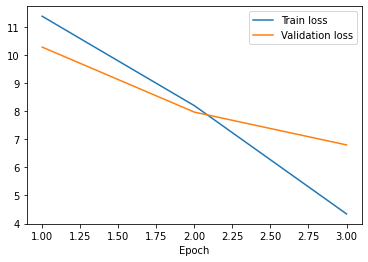

In [48]:
import matplotlib.pyplot as plt

plt.plot(range(1, n_epochs+1), train_loss, label = 'Train loss')
plt.plot(range(1, n_epochs+1), validation_loss, label = 'Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [ ]:
#%% Saving model
model_path = 'drive/My Drive/deep_learning_project/model/'
model.save_pretrained(model_path)